<a href="https://colab.research.google.com/github/superbunny38/2021DeepLearning/blob/main/2_Chap_5_%EC%88%9C%ED%99%98_%EC%8B%A0%EA%B2%BD%EB%A7%9D(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

In [2]:
class RNN:
  def __init__(self, Wx,Wh,b):#초기화
    self.params = [Wx,Wh,b]#가중치 2개+편향 1개
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]#기울기
    self.cache = None#역전파 계산 시 사용하는 중간 데이터를 담을 곳
  
  def forward(self, x, h_prev):#순전파
    Wx, Wh, b = self.params
    t = np.matmul(h_prev, Wh)+np.matmul(x,Wx)+b#h_prev: 하나 앞의 RNN 계층으로부터 받은 입력
    h_next = np.tanh(t)#h_next: 현 시각 RNN계층으로부터의 출력(다음 시각 계층으로의 입력)

    self.cache = (x,h_prev, h_next)
    return h_next
  
  def backward(self, dh_next):#역전파
    Wx, Wh, b = self.params
    x, h_prev, h_next = self.cache

    dt = dh_next * (1-h_next ** 2)
    db = np.sum(dt, axis = 0)
    dWh = np.matmul(h_prev.T, dt)
    dh_prev = np.matmul(dt,Wh.T)
    dWx = np.matmul(x.T, dt)
    dx = np.matmul(dt, Wx.T)

    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db

    return dx, dh_prev

In [3]:
class TimeRNN:
  def __init__(self, Wx, Wh, b, stateful = False):#stateful: 은닉상태를 인계받을지
    #stateful == True: Time RNN 계층이 은닉 상태를 유지한다는 뜻; 아무리 긴 시계열 데이터라도 Time RNN 계층의 순전파를 끊지 않고 전파한다는 뜻
    #stateful == False: 은닉 상태를 영행렬(모든 요소가 0인 행렬)로 초기화(무상태)
    self.params = [Wx,Wh,b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.layers = None#다수의 RNN 계층을 리스트로 저장하는 용도

    self.h, self.dh = None, None#h: forward() 메서드를 불렀을 때의 마지막 RNN 계층의 은닉 상태를 저장 dh: backward()를 불렀을 때 하나 앞 블록의 은닉 상태의 기울기를 저장
    self.stateful = stateful

  def set_state(self, h):#은닉 상태를 설정
    self.h = h
  
  def reset_state(self):#은닉 상태 초기화
    self.h = None

  def forward(self, xs):#순전파(RNN계층의 순전파에서는 출력이 2개로 분기됨)
    Wx, Wh, b = self.params#xs: T개 분량의 시계열 데이터를 하나로 모은 것
    N, T, D = xs.shape#N: 미니배치 크기, D: 입력 벡터의 차원 수
    D, H = Wx.shape

    self.layers = []
    hs = np.empty((N,T,H),dtype = 'f')

    if not self.stateful or self.h is None:
      self.h = np.zeros((N,H), dtype = 'f')#h: RNN 계층의 은닉 상태, 영행렬로 초기화

  def backward(self, dhs):#역전파
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D, H = Wx.shape

    dxs = np.empty((N,T, D), dtype = 'f')#가장 먼저 하류로 흘러보낼 기울기를 담을 그릇
    dh = 0
    grads = [0,0,0]
    for t in reversed(range(T)):
      layer = self.layers[t]
      dx, dh = layer.backward(dhs[:,t,:]+dh)#합산된 기울기
      dxs[:,t,:] = dx
      
      for i, grad in enumerate(layer.grads):
        grads[i]+= grad#가중치 기울기를 합산
    
    for i, grad in enumerate(grads):
      self.grads[i][...] = grad
    self.dh = dh

    return dxs

In [21]:
#깃허브에서 가져옴
# coding: utf-8
from common.np import *  # import numpy as np (or import cupy as np)
from common.layers import *
from common.functions import sigmoid
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None


class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx


class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelㅇㅔ 해당하는 데이터는 기울기를 0으로 설정

        dx = dx.reshape((N, T, V))

        return dx


class TimeDropout:
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flg = True

    def forward(self, xs):
        if self.train_flg:
            flg = np.random.rand(*xs.shape) > self.dropout_ratio
            scale = 1 / (1.0 - self.dropout_ratio)
            self.mask = flg.astype(np.float32) * scale

            return xs * self.mask
        else:
            return xs

    def backward(self, dout):
        return dout * self.mask


In [28]:
import sys
sys.path.append('..')
from common.time_layers import *
from numpy.core.multiarray import dot

class SimpleRnnlm:#4개의 Time 계층을 쌓은 신경망
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    #가중치 초기화(xavier초깃값 사용)
    embed_W = (rn(V,H)/100).astype('f')
    rnn_Wx = (rn(D,H)/np.sqrt(D)).astype('f')
    rnn_Wh = (rn(H,H)/np.sqrt(H)).astype('f')

    rnn_b = np.zeros(H).astype('f')
    affine_W = (rn(H,V)/np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    #계층 생성
    self.layers = [
                   TimeEmbedding(embed_W),
                   TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful = True),
                   TimeAffine(affine_W, affine_b)

    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.rnn_layer = self.layers[1]

    #모든 가중치와 기울기를 리스트에 모은다
    self.params, self.grads = [],[]
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads

  def forward(self, xs, ts):
    for layer in self.layers:
      xs = layer.forward(xs)
    loss = self.loss_layer.forward(xs,ts)
    return loss
  
  def backward(self, dout = 1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout
  
  def reset_state(self):
    self.rnn_layer.reset_state()


### 언어 모델의 예측 성능 평가 척도: Perplexity(혼란도)
: 확률의 역수(작을 수록 좋다)
<br>
#### 해석 방법: 분기수(number of branches)
: 다음에 출현할 수 있는 단어의 후보 수 (최솟값: 1)

In [6]:
%cd /content/drive/MyDrive/DL

/content/drive/MyDrive/DL


In [7]:
!git clone https://github.com/WegraLee/deep-learning-from-scratch-2.git original

Cloning into 'original'...
remote: Enumerating objects: 606, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 606 (delta 1), reused 5 (delta 0), pack-reused 598
Receiving objects: 100% (606/606), 29.82 MiB | 13.15 MiB/s, done.
Resolving deltas: 100% (361/361), done.


In [20]:
%cd original

/content/drive/My Drive/DL/original


In [8]:
!mv /content/drive/MyDrive/DL/original/common /content/drive/MyDrive/DL

In [9]:
!mv /content/drive/MyDrive/DL/original/dataset /content/drive/MyDrive/DL

## RNNLM의 학습코드

PTB 데이터셋을 이용(1000개 단어만 활용)

In [30]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb


In [31]:
#하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100#RNN 은닉 상태 벡터의 원소 수
time_size = 5#Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

In [32]:
#학습 데이터 읽기(전체 중 100개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus)+1)

In [33]:
xs = corpus[:-1]#입력
ts = corpus[1:]#출력(정답 레이블)
data_size = len(xs)
print("말뭉치 크기: %d, 어휘 수: %d"%(corpus_size, vocab_size))

말뭉치 크기: 1000, 어휘 수: 418


In [34]:
#학습시 사용하는 변수
max_iters = data_size//(batch_size*time_size)
time_idx = 0
total_loss =0
loss_count = 0
ppl_list = []

In [35]:
#모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)

In [36]:
#옵티마이저
optimizer = SGD(lr)

In [37]:
#각 미니 배치에서 샘플을 읽기 시작 위치를 계산
jump = (corpus_size - 1)//batch_size
offsets =[i*jump for i in range(batch_size)]#각 미니배치가 데이터 읽기 시작하는 위치를 계산해 offsets에 저장(각 원소에 데이터를 읽는 시작위치가 담기게 됨)

In [38]:
for epoch in range(max_epoch):
  for iter in range(max_iters):
    #미니 배치 획득(데이터를 순차적으로 읽음)
    batch_x = np.empty((batch_size, time_size), dtype = 'i')
    batch_t = np.empty((batch_size, time_size), dtype = 'i')
    for t in range(time_size):
      for i, offset in enumerate(offsets):
        batch_x[i,t] = xs[(offset+time_idx)%data_size]
        batch_t[i,t] = ts[(offset+time_idx)%data_size]
      time_idx += 1
    
    #기울기를 구하여 매개변수 갱신
    loss = model.forward(batch_x, batch_t)
    model.backward()
    optimizer.update(model.params, model.grads)
    total_loss += loss
    loss_count +=1
  
  #에폭마다 perplexity 평가
  ppl = np.exp(total_loss/loss_count)#손실의 평균을 사용해 퍼플렉시티를 구함
  print("| 에폭 %d | 퍼플렉시티 %.2f"%(epoch+1, ppl))
  ppl_list.append(float(ppl))
  total_loss, loss_count = 0,0

| 에폭 1 | 퍼플렉시티 361.82
| 에폭 2 | 퍼플렉시티 245.89
| 에폭 3 | 퍼플렉시티 219.52
| 에폭 4 | 퍼플렉시티 214.28
| 에폭 5 | 퍼플렉시티 204.96
| 에폭 6 | 퍼플렉시티 202.71
| 에폭 7 | 퍼플렉시티 198.73
| 에폭 8 | 퍼플렉시티 196.89
| 에폭 9 | 퍼플렉시티 191.86
| 에폭 10 | 퍼플렉시티 192.94
| 에폭 11 | 퍼플렉시티 189.00
| 에폭 12 | 퍼플렉시티 192.41
| 에폭 13 | 퍼플렉시티 190.31
| 에폭 14 | 퍼플렉시티 191.21
| 에폭 15 | 퍼플렉시티 190.32
| 에폭 16 | 퍼플렉시티 187.32
| 에폭 17 | 퍼플렉시티 184.70
| 에폭 18 | 퍼플렉시티 181.32
| 에폭 19 | 퍼플렉시티 182.65
| 에폭 20 | 퍼플렉시티 183.58
| 에폭 21 | 퍼플렉시티 181.12
| 에폭 22 | 퍼플렉시티 177.70
| 에폭 23 | 퍼플렉시티 174.08
| 에폭 24 | 퍼플렉시티 176.72
| 에폭 25 | 퍼플렉시티 174.67
| 에폭 26 | 퍼플렉시티 173.16
| 에폭 27 | 퍼플렉시티 168.73
| 에폭 28 | 퍼플렉시티 167.50
| 에폭 29 | 퍼플렉시티 165.18
| 에폭 30 | 퍼플렉시티 158.73
| 에폭 31 | 퍼플렉시티 159.57
| 에폭 32 | 퍼플렉시티 153.97
| 에폭 33 | 퍼플렉시티 154.67
| 에폭 34 | 퍼플렉시티 149.89
| 에폭 35 | 퍼플렉시티 149.92
| 에폭 36 | 퍼플렉시티 142.50
| 에폭 37 | 퍼플렉시티 139.66
| 에폭 38 | 퍼플렉시티 136.11
| 에폭 39 | 퍼플렉시티 130.50
| 에폭 40 | 퍼플렉시티 124.27
| 에폭 41 | 퍼플렉시티 125.39
| 에폭 42 | 퍼플렉시티 118.86
| 에폭 43 | 퍼플렉시티 114.36
| 에폭 44 | 퍼플렉시티 108.

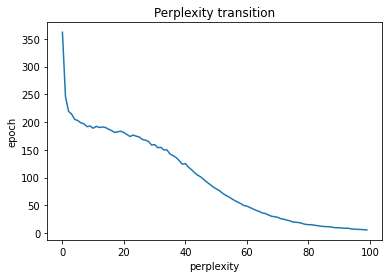

last perplexity:  5.891688240554667


In [43]:
plt.title("Perplexity transition")
plt.plot(ppl_list)
plt.ylabel("epoch")
plt.xlabel("perplexity")
plt.show()
print("last perplexity: ",ppl_list[-1])

RNNLM의 Trainer 클래스 (책 내에 구현)

1. 미니배치를 '순차적'으로 만들어
2. 모델의 순전파와 역전파를 호출하고
3. 옵티마이저로 가중치를 갱신하고
4. 퍼플렉시티를 구합니다

In [44]:
from common.trainer import RnnlmTrainer

In [45]:
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs,ts,max_epoch, batch_size, time_size)

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 417.94
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 384.71
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 263.79
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 219.64
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 208.87
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 206.94
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 200.01
| 에폭 8 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 199.70
| 에폭 9 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 194.16
| 에폭 10 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 190.44
| 에폭 11 |  반복 1 / 19 | 시간 1[s] | 퍼플렉서티 191.63
| 에폭 12 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 189.64
| 에폭 13 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 193.11
| 에폭 14 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 186.77
| 에폭 15 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 185.98
| 에폭 16 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 190.13
| 에폭 17 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 188.41
| 에폭 18 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 183.73
| 에폭 19 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 180.31
| 에폭 20 |  반복 1 / 19 | 시간 2[s] | 퍼플렉서티 180.86
| 에폭 21 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 177.97
| 에폭 22 |  반복 1 / 19 | 시간 3[s] | 퍼플렉서티 178.